In [96]:
import pandas as pd
import numpy as np
import utils

# Data Wrangling:

## Sets:
- $Songs$: set of all songs
- $ExploratorySongs$: subset of songs that are exploratory
- $Artists$: set of all artists
- $PopularArtists$: subset of artists with more than 50,000,000 scrobbles
- $Positions$: set of positions in the playlist (1 to 100)

## Data:
- $Genre_i$: genre of song $i$
- $Artist_i$: artist of song $i$
- $Ratings_i$: rating of song $i$
- $Scrobbles_j$: number of scrobbles for artist $j$
- $NextBestGenre$: the next best genre to explore




In [97]:
# define the datasets


# - $Songs$: set of all songs
# - $ExploratorySongs$: subset of songs that are exploratory (rating = 0)
# - $Artists$: set of all artists
# - $PopularArtists$: subset of artists with more than 50,000,000 scrobbles
# - $Positions$: set of positions in the playlist (1 to 100)

songs = pd.read_csv('songs_with_normalized_ratings.csv')
exploratory_songs = songs[songs['average_prediction'] == 0]

artists = pd.read_csv('artists_with_genres.csv')
popular_artists = artists[artists['scrobbles_lastfm'] > 50000000]
position = list(range(1,101))

# information in songs:
# - $Artist_i$: artist of song $i$
# - $Ratings_i$: rating of song $i$
# - $Genre_i$: genre of song based on genre of artists $i$

/var/folders/vh/hr9y9xbx3tv6jypl81p3lxk80000gn/T/ipykernel_13540/699585712.py:13: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  artists = pd.read_csv('artists_with_genres.csv')


In [98]:
# Create a new column for genre if it doesn't exist
if 'genre' not in songs.columns:
    songs['genre'] = None

# Create a dictionary mapping artist names to their tags for faster lookup
artist_tags_dict = dict(zip(artists['artist_mb'], artists['tags']))

# Use vectorized operations instead of iterating through each row
songs['genre'] = songs['artist_name'].map(artist_tags_dict)

# Collaborative Filtering to Find Next Best Genre

## Process:
1. For each user, calculate their genre preferences
2. Find top 3 most similar users
3. Identify next best genre to explore

## Genre Preference Calculation:
For each user, we track per-genre statistics:

user_1: [genre_1 :(total_rating, avg_rating, count), genre_2: (total_rating, avg_rating, count), ... , genre_k]

user_2: ...

...

user_k: ...

See implementation in `utils.py`

# Mathematical Formulation for Song Selection Model

## Parameters:
- $w_1, w_2$: weights for balancing rating quality and artist diversity
- $e_1$: minimum number of exploratory songs
- $e_2$: minimum number of songs from next best genre
- $a$: maximum number of popular artists allowed

## Decision Variables:
- $S_i$: binary variable, equals 1 if song $i$ is selected for the playlist, 0 otherwise
- $A_j$: binary variable, equals 1 if artist $j$ is represented in the playlist, 0 otherwise

## Objective Function:
Maximize: $w_1 \cdot \sum_{i \in Songs} Ratings_i \cdot S_i + \frac{w_2}{100} \cdot \sum_{j \in Artists} A_j$

## Constraints:
1. At least 100 songs: $\sum_{i \in Songs} S_i \geq 100$
2. Explore songs from exploratory set: $\sum_{i \in ExploratorySongs} S_i \geq e_1$
3. Explore songs from the next best genre: $\sum_{i \in Songs, Genre_i = NextBestGenre} S_i \geq e_2$
4. Map Artists to Songs: $A_j \leq \sum_{i \in Songs, Artist_i = j} S_i \quad \forall j \in Artists$
5. Limit total number of popular artists: $\sum_{j \in PopularArtists} A_j \leq a$
6. Constraint on exploratory parameters: $e_1 + e_2 \leq 100$

In [99]:
# Extract data from dataframes
songs_data = songs
artists_data = artists

# Create sets
all_songs = list(range(len(songs_data)))
all_artists = list(artists_data['artist_mb'].unique())
exploratory_songs_indices = list(exploratory_songs.index)
popular_artists_list = list(popular_artists['artist_mb'])

# Parameters
user = "user_5c0cba28e67a99c235ef2ba9877fef44"
w1 = 0.5  # Weight for song ratings
w2 = 0.5  # Weight for artist diversity
e1 = 10   # Minimum number of exploratory songs
e2 = 5    # Minimum number of songs from next best genre
a = 20    # Maximum number of popular artists allowed

# Get next best genre
# For a specific user, find 3 most similar users and their favorite genres that we already dont find the top 2
user_genre_preferences = utils.calculate_genre_preferences(songs)
similar_users = utils.find_similar_users(user, user_genre_preferences, n=3)
next_best_genre = utils.find_next_best_genre(user, user_genre_preferences, similar_users, k=2)
print(f"Next best genre to explore: {next_best_genre}")

Next best genre to explore: punk


In [100]:
from gurobipy import Model, GRB, quicksum

# Create a new model
model = Model("Song_Selection_Model")

# Create decision variables
S = model.addVars(all_songs, vtype=GRB.BINARY, name="S")
A = model.addVars(all_artists, vtype=GRB.BINARY, name="A_")
print("Created decision variables")

# Objective function: maximize weighted sum of ratings and artist diversity
model.setObjective(
    w1 * quicksum(songs_data.iloc[i][user] * S[i] for i in all_songs) +
    w2 / 100 * quicksum(A[j] for j in all_artists),
    GRB.MAXIMIZE
)
print("Set objective function")

# Constraint 1: At most 100 songs (changed from at least to at most)
model.addConstr(quicksum(S[i] for i in all_songs) <= 100, "max_songs")
print("Added constraint 1: maximum songs")

# Constraint 2: Minimum number of exploratory songs
model.addConstr(quicksum(S[i] for i in exploratory_songs_indices) >= e1, "min_exploratory")
print("Added constraint 2: minimum exploratory songs")

# Constraint 3: Minimum number of songs from next best genre
# Pre-compute indices to avoid repeated iloc lookups
next_best_genre_indices = []
for i in all_songs:
    if isinstance(songs_data.iloc[i]['genre'], str) and next_best_genre in songs_data.iloc[i]['genre']:
        next_best_genre_indices.append(i)
print(f"Found {len(next_best_genre_indices)} songs in next best genre")
model.addConstr(quicksum(S[i] for i in next_best_genre_indices) >= e2, "min_next_best_genre")
print("Added constraint 3: minimum next best genre songs")

# Constraint 4: Map Artists to Songs
# Create a dictionary to map artists to their songs to avoid repeated lookups
artist_to_songs = {}
for j in all_artists:
    artist_to_songs[j] = []

# Populate the dictionary
for i in all_songs:
    artist_name = songs_data.iloc[i]['artist_name']
    # Fix: Check if artist_name exists in artist_to_songs dictionary
    if artist_name in all_artists:
        artist_to_songs[artist_name].append(i)
print(f"Created artist-to-songs mapping with {len(artist_to_songs)} artists")

# Add constraints using the pre-computed mapping
print("Adding artist mapping constraints (this may take a while)...")
count = 0
for j in all_artists:
    # Only add constraint if the artist has songs in our dataset
    if artist_to_songs[j]:  # Check if the list is not empty
        model.addConstr(A[j] <= quicksum(S[i] for i in artist_to_songs[j]), f"artist_map_{j}")
        count += 1
        if count % 1000 == 0:
            print(f"  Added {count}/{len(all_artists)} artist constraints", end="\r")
print(f"Added constraint 4: {count} artist mapping constraints")

# Constraint 5: Limit total number of popular artists
popular_artist_vars = [A[j] for j in all_artists if j in popular_artists_list]
print(f"Found {len(popular_artist_vars)} popular artists")
model.addConstr(quicksum(popular_artist_vars) <= a, "max_popular_artists")
print("Added constraint 5: maximum popular artists")

# Constraint 6: Constraint on exploratory parameters
# This is already enforced by our parameter choices, but we add it for completeness
model.addConstr(e1 + e2 <= 100, "exploratory_limit")
print("Added constraint 6: exploratory limit")
print("All constraints added, ready to optimize")

# Optimize the model
print("Optimizing the model...")
model.optimize()

# Print results if optimal solution found
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    if model.status == GRB.TIME_LIMIT:
        print("Time limit reached. Using best solution found.")
    else:
        print(f"Optimal objective value: {model.objVal:.4f}")
    
    # Get selected songs
    selected_songs = [i for i in all_songs if S[i].X > 0.5]
    selected_songs_df = songs_data.iloc[selected_songs]
    
    # Get selected artists
    selected_artists = [j for j in all_artists if A[j].X > 0.5]
else:
    print(f"No optimal solution found. Status code: {model.status}")
    
    # Print infeasibility diagnostics
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
        model.computeIIS()
        print("The following constraints cannot be satisfied simultaneously:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f"  {c.ConstrName}")


Created decision variables
Set objective function
Added constraint 1: maximum songs
Added constraint 2: minimum exploratory songs
Found 4063 songs in next best genre
Added constraint 3: minimum next best genre songs
Created artist-to-songs mapping with 1352995 artists
Adding artist mapping constraints (this may take a while)...
Added constraint 4: 7480 artist mapping constraints
Found 283 popular artists
Added constraint 5: maximum popular artists
Added constraint 6: exploratory limit
All constraints added, ready to optimize
Optimizing the model...
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7485 rows, 1372995 columns and 57076 nonzeros
Model fingerprint: 0x9db87520
Variable types: 0 continuous, 1372995 integer (1372995 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 2e-01]
  

In [101]:
selected_songs_df[["track_name", "artist_name"]]

,track_name,artist_name
5,Una Furtiva Lagrima,Giacomo Puccini
6,Outta Here,Lil Wayne
14,Didn't You,Cloud Nothings
28,Illmerica - Extended Version,Wolfgang Gartner
32,Don't Forget To Remember Me,Carrie Underwood
...,...,...
19426,Lovers In Japan (Acoustic Version),Coldplay
19504,42 [Live],Coldplay
19521,trouble,Coldplay
19548,Strawberry Swing(Live),Coldplay


# Mathematical Formulation for Song Ordering Model

goal: we get a list of all 100 songs picked from the improved model
we then want to order them to artificially create "peaks" within a playlist
we want to maximize the rating every 5 songs in order to create a more engaging playlist

WHY? 
This formulation will create a playlist where higher-rated songs tend to appear at peak positions (multiples of 5), 
creating an engaging listening experience with regular high points.

## Parameters:
- $SelectedSongs$: set of songs selected from the previous model
- $Positions$: set of positions in the playlist (1 to 100)
- $Ratings_i$: rating of song $i$
- $Peaks$: set of peak positions (5, 10, 15, ..., 100)

## Decision Variables:
- $X_{i,j}$: binary variable, equals 1 if song $i$ is placed at position $j$ in the playlist, 0 otherwise

## Objective Function:
Maximize: $\sum_{i \in SelectedSongs} \sum_{j \in Peaks} Ratings_i \cdot X_{i,j}$

## Constraints:
1. Each position must have exactly one song: $\sum_{i \in SelectedSongs} X_{i,j} = 1 \quad \forall j \in Positions$
2. Each selected song must be used exactly once: $\sum_{j \in Positions} X_{i,j} = 1 \quad \forall i \in SelectedSongs$
3. Total number of songs must be 100: $\sum_{i \in SelectedSongs} \sum_{j \in Positions} X_{i,j} = 100$


In [102]:
# Implementation of the Song Ordering Model using Gurobi
from gurobipy import Model, GRB, quicksum

# Create a new model
print("Creating Song Ordering Model...")
ordering_model = Model("Song_Ordering_Model")

# Extract data from the selected songs
selected_songs = list(range(len(selected_songs_df)))
positions = list(range(1, 101))
peaks = [1] + [5*i for i in range(1, 21)]  # 1, 5, 10, 15, ..., 100

# Get ratings for selected songs
ratings = selected_songs_df[user].values

print(f"Number of selected songs: {len(selected_songs)}")
print(f"Peak positions: {peaks}")

# Create decision variables
print("Creating decision variables...")
X = {}
for i in selected_songs:
    for j in positions:
        X[i, j] = ordering_model.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}")

# Set objective function: maximize the sum of ratings at peak positions
print("Setting objective function...")
objective = quicksum(ratings[i] * X[i, j] for i in selected_songs for j in peaks)
ordering_model.setObjective(objective, GRB.MAXIMIZE)

# Add constraints
print("Adding constraints...")

# Constraint 1: Each position must have exactly one song
for j in positions:
    ordering_model.addConstr(quicksum(X[i, j] for i in selected_songs) == 1, f"one_song_per_position_{j}")

# Constraint 2: Each selected song must be used exactly once
for i in selected_songs:
    ordering_model.addConstr(quicksum(X[i, j] for j in positions) == 1, f"use_song_once_{i}")

# Constraint 3: Total number of songs must be 100 (redundant given constraints 1 and 2, but added for completeness)
ordering_model.addConstr(quicksum(X[i, j] for i in selected_songs for j in positions) == 100, "total_songs")

# Optimize the model
print("Optimizing the Song Ordering Model...")
ordering_model.optimize()

# Process results
if ordering_model.status == GRB.OPTIMAL:
    print(f"Optimal objective value: {ordering_model.objVal:.4f}")
    
    # Create a dictionary to store the position of each song
    song_positions = {}
    for i in selected_songs:
        for j in positions:
            if X[i, j].X > 0.5:  # If the variable is set to 1
                song_positions[j] = i
    
    # Create the ordered playlist
    ordered_playlist = pd.DataFrame({
        'position': [],
        'track_name': [],
        'artist_name': [],
        'rating': [],
        'genre': []
    })
    
    for pos in sorted(song_positions.keys()):
        song_idx = song_positions[pos]
        ordered_playlist = pd.concat([ordered_playlist, pd.DataFrame({
            'position': [pos],
            'track_name': [selected_songs_df.iloc[song_idx]['track_name']],
            'artist_name': [selected_songs_df.iloc[song_idx]['artist_name']],
            'rating': [selected_songs_df.iloc[song_idx][user]],
            'genre': selected_songs_df.iloc[song_idx]['genre']
        })], ignore_index=True)
    
    # Display the ordered playlist
    print("\nOrdered Playlist:")
    print(ordered_playlist)
    
    # Highlight the peak positions
    peak_songs = ordered_playlist[ordered_playlist['position'].isin(peaks)]
    print("\nSongs at Peak Positions:")
    print(peak_songs)
    
    # Calculate average rating at peak positions vs. non-peak positions
    avg_rating_peaks = peak_songs['rating'].mean()
    non_peak_songs = ordered_playlist[~ordered_playlist['position'].isin(peaks)]
    avg_rating_non_peaks = non_peak_songs['rating'].mean()
    
    print(f"\Rating at peak positions: {avg_rating_peaks:.4f}")
    print(f"Rating at non-peak positions: {avg_rating_non_peaks:.4f}")
    
else:
    print(f"No optimal solution found. Status code: {ordering_model.status}")


Creating Song Ordering Model...
Number of selected songs: 100
Peak positions: [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
Creating decision variables...
Setting objective function...
Adding constraints...
Optimizing the Song Ordering Model...
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 201 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0x0ad1a67f
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.02s
Presolved: 200 rows, 10000 columns, 20000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective 9.639469

<>:93: SyntaxWarning: invalid escape sequence '\R'
<>:93: SyntaxWarning: invalid escape sequence '\R'
/var/folders/vh/hr9y9xbx3tv6jypl81p3lxk80000gn/T/ipykernel_13540/1827354883.py:93: SyntaxWarning: invalid escape sequence '\R'
  print(f"\Rating at peak positions: {avg_rating_peaks:.4f}")


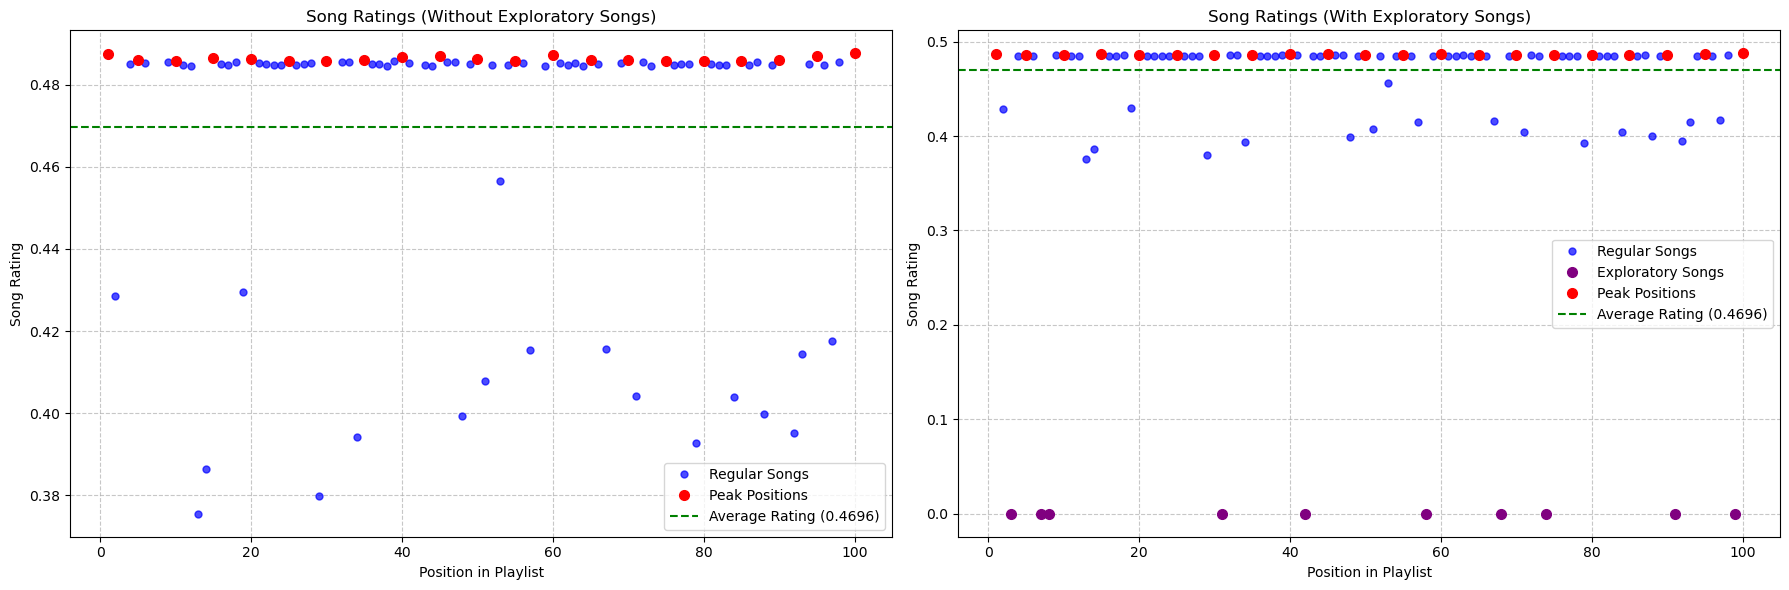

In [103]:
# plot the ratings and positions of the final playlist
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))


exploratory_songs = ordered_playlist[ordered_playlist['rating'] == 0]
regular_songs = ordered_playlist[ordered_playlist['rating'] > 0]

ax1.plot(regular_songs['position'], regular_songs['rating'], 'o', color='blue', alpha=0.7, markersize=5, label='Regular Songs')

peak_regular_songs = peak_songs[peak_songs['rating'] > 0]
ax1.plot(peak_regular_songs['position'], peak_regular_songs['rating'], 'o', color='red', markersize=7, label='Peak Positions')

ax1.set_xlabel('Position in Playlist')
ax1.set_ylabel('Song Rating')
ax1.set_title('Song Ratings (Without Exploratory Songs)')
ax1.grid(True, linestyle='--', alpha=0.7)
avg_rating = regular_songs['rating'].mean() if not regular_songs.empty else 0
ax1.axhline(y=avg_rating, color='green', linestyle='--', 
            label=f'Average Rating ({avg_rating:.4f})')
ax1.legend()

# Second subplot - with exploratory songs
# Plot the regular songs
ax2.plot(regular_songs['position'], regular_songs['rating'], 'o', color='blue', alpha=0.7, markersize=5, label='Regular Songs')

# Plot exploratory songs
if not exploratory_songs.empty:
    ax2.plot(exploratory_songs['position'], exploratory_songs['rating'], 'o', color='purple', markersize=7, label='Exploratory Songs')

# Highlight peak positions
ax2.plot(peak_songs['position'], peak_songs['rating'], 'o', color='red', markersize=7, label='Peak Positions')

ax2.set_xlabel('Position in Playlist')
ax2.set_ylabel('Song Rating')
ax2.set_title('Song Ratings (With Exploratory Songs)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(y=avg_rating, color='green', linestyle='--', 
            label=f'Average Rating ({avg_rating:.4f})')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [104]:
# Convert genre strings to lists if they're in string format
ordered_playlist['genre'] = ordered_playlist['genre'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Count occurrences of each genre
all_genres = []
for genre_list in ordered_playlist['genre']:
    # Skip if not iterable (like float NaN values)
    if isinstance(genre_list, (list, tuple)):
        all_genres.extend(genre_list)

# Create a counter for genres
from collections import Counter
genre_counts = Counter(all_genres)

# Display the most common genres
print("Most common genres:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count}")

Most common genres:
pop: 89
alternative: 85
electronic: 77
punk: 16
jazz: 4
metal: 3
folk: 3
hip hop: 3
soul: 3
classical: 2


Total number of unique genres: 10
Most common genre: pop (89 occurrences)
Total number of unique artists: 31
Most common artist: Coldplay (69 songs)


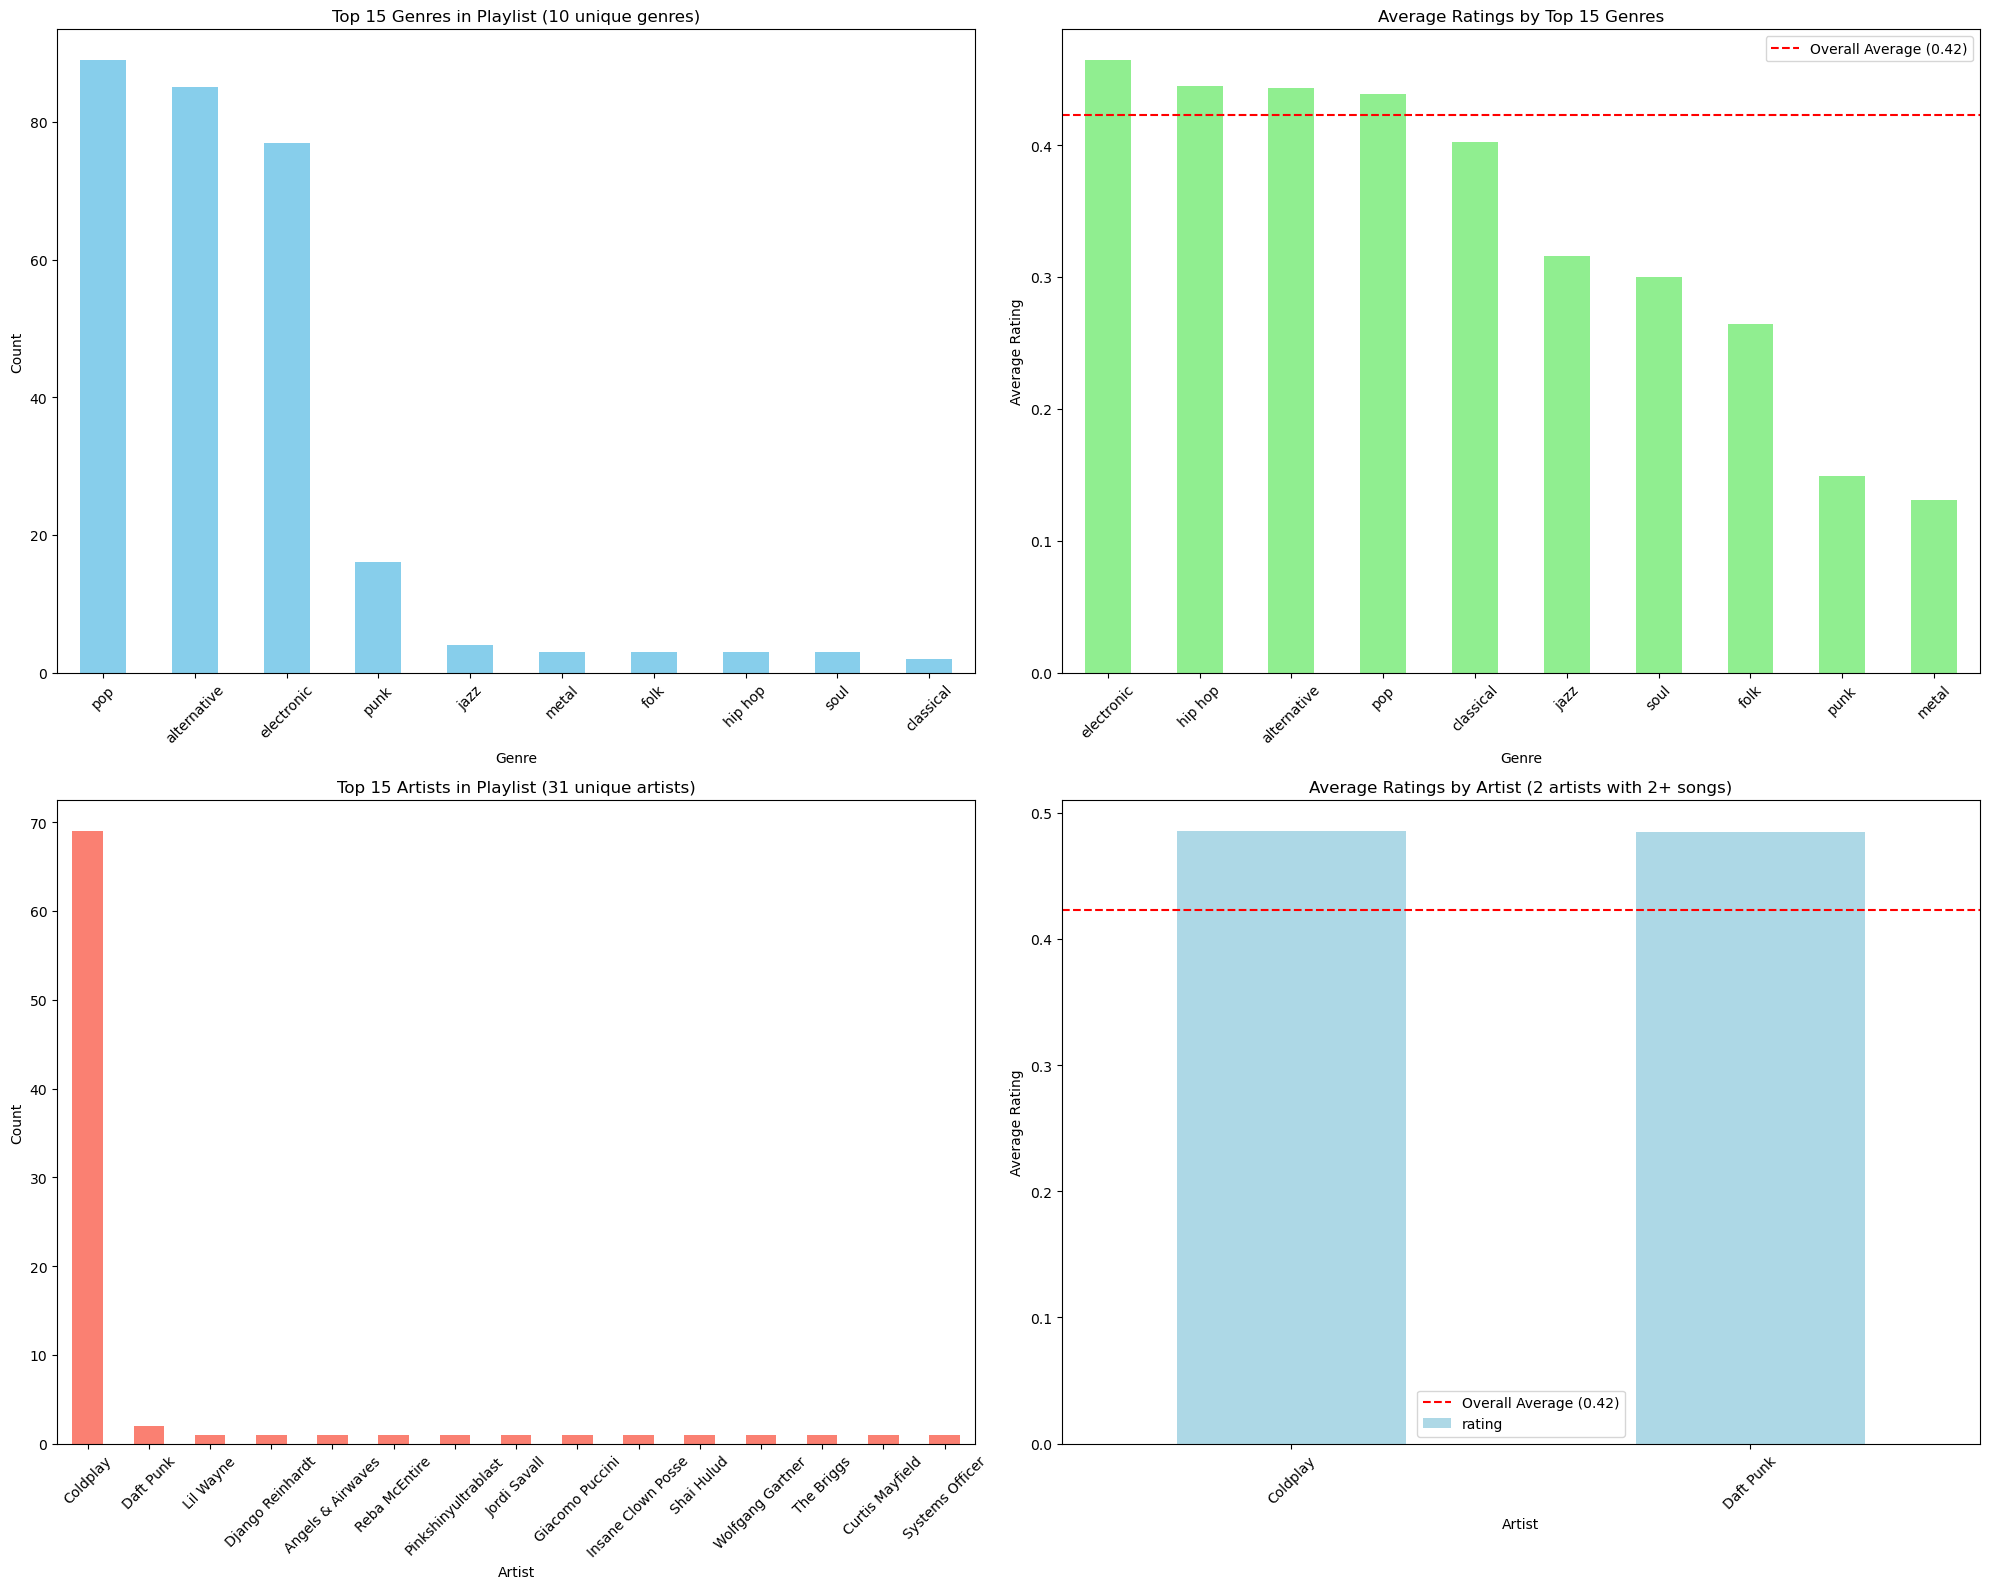

In [106]:
# Analyze the distribution of genres and artists in the playlist

# Create a figure with 2x2 subplots for all visualizations
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Check if we have genre information in our dataset
if 'genre' in ordered_playlist.columns:
    # Create a list of all genres (handling potential NaN values)
    all_genres = []
    for genre_list in ordered_playlist['genre']:
        # Skip if not iterable (like float NaN values)
        if isinstance(genre_list, (list, tuple)):
            all_genres.extend(genre_list)
    
    # Create a DataFrame for genre analysis
    genre_df = pd.DataFrame({'genre': all_genres})
    
    # Plot 1: Genre distribution (top left)
    genre_counts = pd.Series(genre_df['genre'].value_counts().head(15))  # Show top 15 genres
    genre_counts.plot(kind='bar', color='skyblue', ax=axs[0, 0])
    axs[0, 0].set_title(f'Top 15 Genres in Playlist ({len(set(all_genres))} unique genres)')
    axs[0, 0].set_xlabel('Genre')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].tick_params(axis='x', rotation=45, labelrotation=45)
    
    # Plot 2: Ratings by genre (top right)
    # Calculate average rating for each genre
    genre_ratings = {}
    for idx, row in ordered_playlist.iterrows():
        if isinstance(row['genre'], (list, tuple)):
            for genre in row['genre']:
                if genre not in genre_ratings:
                    genre_ratings[genre] = []
                genre_ratings[genre].append(row['rating'])
    
    avg_genre_ratings = {genre: sum(ratings)/len(ratings) 
                         for genre, ratings in genre_ratings.items() 
                         if len(ratings) > 0}
    
    genre_ratings_series = pd.Series(avg_genre_ratings).sort_values(ascending=False).head(15)
    genre_ratings_series.plot(kind='bar', color='lightgreen', ax=axs[0, 1])
    axs[0, 1].set_title(f'Average Ratings by Top 15 Genres')
    axs[0, 1].set_xlabel('Genre')
    axs[0, 1].set_ylabel('Average Rating')
    axs[0, 1].tick_params(axis='x', rotation=45, labelrotation=45)
    axs[0, 1].axhline(y=ordered_playlist['rating'].mean(), color='red', linestyle='--', 
                label=f'Overall Average ({ordered_playlist["rating"].mean():.2f})')
    axs[0, 1].legend()

# Plot 3: Artist distribution (bottom left)
artist_counts = ordered_playlist['artist_name'].value_counts().head(15)  # Show top 15 artists
artist_counts.plot(kind='bar', color='salmon', ax=axs[1, 0])
axs[1, 0].set_title(f'Top 15 Artists in Playlist ({ordered_playlist["artist_name"].nunique()} unique artists)')
axs[1, 0].set_xlabel('Artist')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45, labelrotation=45)

# Plot 4: Ratings by artist (bottom right)
artist_song_counts = ordered_playlist['artist_name'].value_counts()
artists_with_multiple_songs = artist_song_counts[artist_song_counts >= 2].index
if len(artists_with_multiple_songs) > 0:
    artist_ratings = ordered_playlist[ordered_playlist['artist_name'].isin(artists_with_multiple_songs)]\
                    .groupby('artist_name')['rating'].mean().sort_values(ascending=False)
    artist_ratings.plot(kind='bar', color='lightblue', ax=axs[1, 1])
    axs[1, 1].set_title(f'Average Ratings by Artist ({len(artists_with_multiple_songs)} artists with 2+ songs)')
    axs[1, 1].set_xlabel('Artist')
    axs[1, 1].set_ylabel('Average Rating')
    axs[1, 1].tick_params(axis='x', rotation=45, labelrotation=45)
    axs[1, 1].axhline(y=ordered_playlist['rating'].mean(), color='red', linestyle='--', 
                label=f'Overall Average ({ordered_playlist["rating"].mean():.2f})')
    axs[1, 1].legend()

# Print some statistics about genres and artists
if 'genre' in ordered_playlist.columns:
    # Count unique genres across all songs
    all_unique_genres = set()
    for genre_list in ordered_playlist['genre']:
        # Skip if not iterable (like float NaN values)
        if isinstance(genre_list, (list, tuple)):
            all_unique_genres.update(genre_list)
    
    # Find most common genre
    from collections import Counter
    genre_counts = Counter(all_genres)
    most_common_genre = genre_counts.most_common(1)[0][0]
    most_common_genre_count = genre_counts.most_common(1)[0][1]
    
    print(f"Total number of unique genres: {len(all_unique_genres)}")
    print(f"Most common genre: {most_common_genre} ({most_common_genre_count} occurrences)")
else:
    print("Genre information not available")

print(f"Total number of unique artists: {ordered_playlist['artist_name'].nunique()}")
print(f"Most common artist: {ordered_playlist['artist_name'].value_counts().index[0]} "
      f"({ordered_playlist['artist_name'].value_counts().iloc[0]} songs)")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
